In [59]:
import pandas as pd
import warnings
import numpy as np
import plotly.graph_objs as go
import plotly.express as px 
from fbprophet import Prophet
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving daily_aqi_by_cbsa_2020.csv to daily_aqi_by_cbsa_2020.csv
Saving daily_aqi_by_county_2020.csv to daily_aqi_by_county_2020.csv


In [60]:
AirQualitybycbsa=pd.read_csv("daily_aqi_by_cbsa_2020.csv")

In [61]:
AirQualitybycbsa.head()

,CBSA,CBSA Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,"Aberdeen, WA",10140,2020-01-01,40,Good,PM2.5,53-027-0011,2
1,"Aberdeen, WA",10140,2020-01-02,17,Good,PM2.5,53-027-2002,2
2,"Aberdeen, WA",10140,2020-01-03,40,Good,PM2.5,53-027-0011,2
3,"Aberdeen, WA",10140,2020-01-04,23,Good,PM2.5,53-027-0011,2
4,"Aberdeen, WA",10140,2020-01-05,18,Good,PM2.5,53-027-0011,2


In [62]:
AirQualitybycounty=pd.read_csv("daily_aqi_by_county_2020.csv")

In [63]:
AirQualitybycounty.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1


In [64]:
df = pd.pivot_table(AirQualitybycounty, values='AQI', index=['Date'],columns='State Name', aggfunc=np.average)
Top5=df[list(pd.DataFrame(df.mean().sort_values().tail(5)).reset_index()['State Name'])]
# ploty
layout = go.Layout(
  title="Air Quality Index of 5 states having maximum Air Quality Index",
  xaxis=dict(
      title="Timeline"
  ),
  yaxis=dict(
      title="Air Quality Index"
  ) ) 
fig = go.Figure(layout=layout)
for col in Top5.columns:
    fig.add_trace(go.Scatter(x=Top5.index, y=Top5[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             )
                 )

fig.show()

In [65]:
df=pd.DataFrame(df.mean().sort_values().tail(10)).reset_index()
df.columns=['State Name','Mean Air Quality']

fig = px.pie(df, values='Mean Air Quality', names="State Name",title="Staets with maximum Air Quality (Top 10)") 
fig.show()

In [66]:
Updated=Top5.reset_index()

In [67]:

Jefferson=Updated[['Date','California']]
Jefferson=Jefferson.dropna()
new_data = pd.DataFrame(index=range(0,len(Jefferson)),columns=['Date', 'California'])
for i in range(0,len(Jefferson)):
    new_data['Date'][i] = Jefferson['Date'][i]
    new_data['California'][i] = Jefferson['California'][i]
new_data.shape
new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']
#preparing data
new_data.rename(columns={'California': 'y', 'Date': 'ds'}, inplace=True)
#train and validation
train = new_data[:80]
valid = new_data[80:]
#fit the model
model = Prophet(weekly_seasonality=True,yearly_seasonality=False,daily_seasonality=True,n_changepoints=2,changepoint_prior_scale=0.002,interval_width=0.3)
model.fit(train)
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
new_data.shape

(121, 2)

In [68]:
#rmse
forecast_valid = forecast['yhat_upper'][80:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print("Root Mean Sequare Error is: ",rms)

Root Mean Sequare Error is:  7.283959730231624


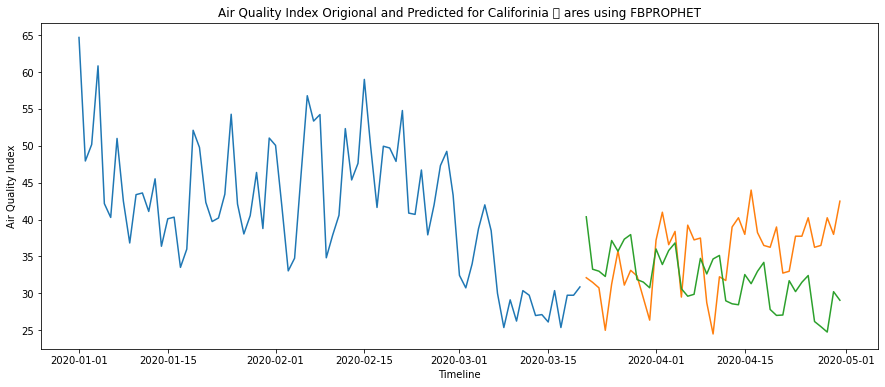

In [69]:
#plot
valid['Predictions'] = forecast_valid.values
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index Origional and Predicted for Califorinia 	 ares using FBPROPHET")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [70]:
Updated['Date']

0      2020-01-01
1      2020-01-02
2      2020-01-03
3      2020-01-04
4      2020-01-05
          ...    
129    2020-05-09
130    2020-05-10
131    2020-05-11
132    2020-05-12
133    2020-05-13
Name: Date, Length: 134, dtype: object

In [71]:
days=list()
i=0
a1=new_data.reset_index()[-1:]['Date'].values[0]
while i<30:
  a1=a1+np.timedelta64(1,'D')
  days.append(a1)
  i=i+1

In [72]:
data=pd.DataFrame(days)
data.columns=['ds']

In [73]:
data

,ds
0,2020-05-01
1,2020-05-02
2,2020-05-03
3,2020-05-04
4,2020-05-05
5,2020-05-06
6,2020-05-07
7,2020-05-08
8,2020-05-09
9,2020-05-10


In [74]:
fure = model.predict((data))

In [75]:
fure

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-01,-25.095534,24.674879,30.011991,-25.095534,-25.095534,52.540355,52.540355,52.540355,50.186408,50.186408,50.186408,2.353947,2.353947,2.353947,0.0,0.0,0.0,27.444822
1,2020-05-02,-25.296284,26.097834,31.649201,-25.296284,-25.296284,53.850357,53.850357,53.850357,50.186408,50.186408,50.186408,3.663949,3.663949,3.663949,0.0,0.0,0.0,28.554073
2,2020-05-03,-25.497034,19.521823,25.102980,-25.497034,-25.497034,47.633920,47.633920,47.633920,50.186408,50.186408,50.186408,-2.552488,-2.552488,-2.552488,0.0,0.0,0.0,22.136886
3,2020-05-04,-25.697784,18.937866,24.092982,-25.697784,-25.697784,47.345503,47.345503,47.345503,50.186408,50.186408,50.186408,-2.840905,-2.840905,-2.840905,0.0,0.0,0.0,21.647719
4,2020-05-05,-25.898534,18.583466,24.193423,-25.898534,-25.898534,47.174373,47.174373,47.174373,50.186408,50.186408,50.186408,-3.012035,-3.012035,-3.012035,0.0,0.0,0.0,21.275839
5,2020-05-06,-26.099284,23.115872,28.703921,-26.099284,-26.099284,52.079643,52.079643,52.079643,50.186408,50.186408,50.186408,1.893235,1.893235,1.893235,0.0,0.0,0.0,25.980359
6,2020-05-07,-26.300034,21.805062,27.354909,-26.300034,-26.300034,50.680705,50.680705,50.680705,50.186408,50.186408,50.186408,0.494297,0.494297,0.494297,0.0,0.0,0.0,24.380671
7,2020-05-08,-26.500784,23.587924,28.826178,-26.500784,-26.500784,52.540355,52.540355,52.540355,50.186408,50.186408,50.186408,2.353947,2.353947,2.353947,0.0,0.0,0.0,26.039571
8,2020-05-09,-26.701534,24.463987,29.822029,-26.701534,-26.701534,53.850357,53.850357,53.850357,50.186408,50.186408,50.186408,3.663949,3.663949,3.663949,0.0,0.0,0.0,27.148823
9,2020-05-10,-26.902284,17.593002,23.073734,-26.902284,-26.902284,47.633920,47.633920,47.633920,50.186408,50.186408,50.186408,-2.552488,-2.552488,-2.552488,0.0,0.0,0.0,20.731636


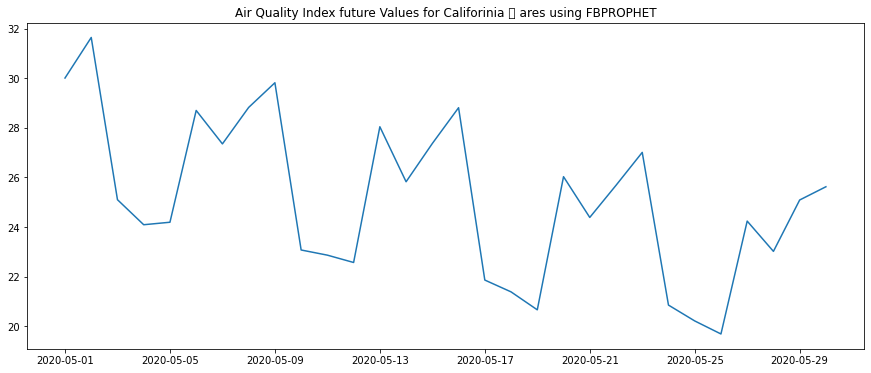

In [76]:
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index future Values for Califorinia 	 ares using FBPROPHET")
plt.plot(fure['ds'],fure['yhat_upper'])

In [77]:
California=Updated[['Date','California']]
California=California.dropna()
California['Date'] = pd.to_datetime(California['Date'])
new_data = pd.DataFrame()
new_data['Date'] = California['Date']
new_data['California'] = California['California']
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
#creating train and test sets
dataset = new_data.values
train = dataset[0:70,:]
valid = dataset[70:,:]
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

10/10 - 0s - loss: 0.0389


In [78]:
inputs1 = new_data[-60:].values
Loop = 0
L_a95 = list()
while Loop<30:
    inputs = inputs1.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(30,inputs.shape[0]):
        X_test.append(inputs[i-30:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    X_test=X_test[-1:]
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    closing_price=int(closing_price)
    inputs1 = np.append(inputs1,closing_price)
    L_a95.append(closing_price)
    Loop=Loop+1

In [79]:
days=list()
i=0
a1=new_data.reset_index()[-1:]['Date'].values[0]
while i<30:
  a1=a1+np.timedelta64(1,'D')
  days.append(a1)
  i=i+1

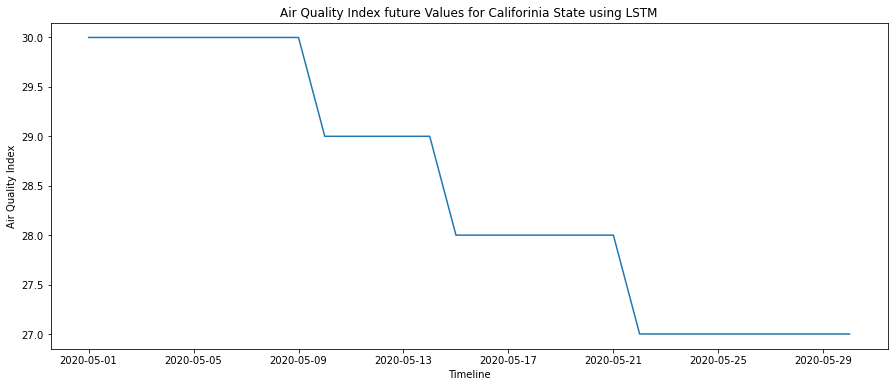

In [80]:
Final=pd.DataFrame(L_a95)
Final.index=days
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index future Values for Califorinia State using LSTM")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(Final)

In [81]:
df = pd.pivot_table(AirQualitybycounty, values='AQI', index=['Date'],columns='State Name', aggfunc=np.average)
Bottom5=df[list(pd.DataFrame(df.mean().sort_values().head(10)).reset_index()['State Name'])]
# ploty
layout = go.Layout(
  title="Air Quality Index of 10 states having mminimum Air Quality Index",
  xaxis=dict(
      title="Timeline"
  ),
  yaxis=dict(
      title="Air Quality Index"
  ) ) 
fig = go.Figure(layout=layout)
for col in Bottom5.columns:
    fig.add_trace(go.Scatter(x=Bottom5.index, y=Bottom5[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             )
                 )
fig.show()

In [82]:
df=pd.DataFrame(df.mean().sort_values().head(10)).reset_index()
df.columns=['State Name','Mean Air Quality']
fig = px.pie(df, values='Mean Air Quality', names="State Name",title="Staets with minimum Air Quality (Least 10)") 
fig.show()

In [83]:
df = pd.pivot_table(AirQualitybycounty, values='AQI', index=['Date'],columns='county Name', aggfunc=np.average)
Top5=df[list(pd.DataFrame(df.mean().sort_values().tail(5)).reset_index()['county Name'])]
# ploty
layout = go.Layout(
  title="Air Quality Index of 5 counties having maximum Air Quality Index",
  xaxis=dict(
      title="Timeline"
  ),
  yaxis=dict(
      title="Air Quality Index"
  ) ) 
fig = go.Figure(layout=layout)
for col in Top5.columns:
    fig.add_trace(go.Scatter(x=Top5.index, y=Top5[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             )
                 )
fig.show()

In [84]:
df=pd.DataFrame(df.mean().sort_values().tail(10)).reset_index()
df.columns=['county Name','Mean Air Quality']
fig = px.pie(df, values='Mean Air Quality', names="county Name",title="Counties with maximum Air Quality (Top 10)") 
fig.show()

In [85]:
Top5

county Name,Plumas,Okanogan,Merced,Missoula,Matanuska-Susitna
Date,,,,,
2020-01-01,94.0,60.0,85.0,49.0,NaN
2020-01-02,64.0,53.0,NaN,31.0,NaN
2020-01-03,77.0,51.0,NaN,71.0,NaN
2020-01-04,69.0,40.0,69.0,64.0,87.0
2020-01-05,55.0,59.0,NaN,35.0,NaN
...,...,...,...,...,...
2020-05-09,NaN,NaN,NaN,NaN,NaN
2020-05-10,NaN,NaN,NaN,NaN,NaN
2020-05-11,NaN,NaN,NaN,NaN,NaN


In [86]:
Updated=Top5.reset_index()

Jefferson=Updated[['Date','Plumas']]
Jefferson=Jefferson.dropna()
Jefferson=Jefferson.reset_index()
new_data = pd.DataFrame(index=range(0,len(Jefferson)),columns=['Date', 'Plumas'])
for i in range(0,len(Jefferson)):
    new_data['Date'][i] = Jefferson['Date'][i]
    new_data['Plumas'][i] = Jefferson['Plumas'][i]
new_data.shape
new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']
#preparing data
new_data.rename(columns={'Plumas': 'y', 'Date': 'ds'}, inplace=True)
#train and validation
train = new_data[:80]
valid = new_data[80:]
#fit the model
model = Prophet(weekly_seasonality=True,yearly_seasonality=False,daily_seasonality=True)
model.fit(train)
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)
new_data.shape

(115, 2)

In [87]:
#rmse
forecast_valid = forecast['yhat'][80:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print("Root Mean Sequare Error is: ",rms)

Root Mean Sequare Error is:  23.96123157759849


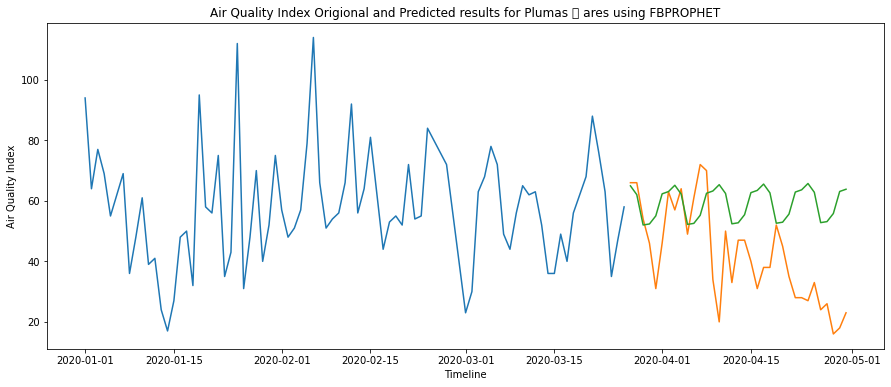

In [88]:
#plot
valid['Predictions'] = forecast_valid.values
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index Origional and Predicted results for Plumas 	 ares using FBPROPHET")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [89]:
California=Jefferson[['Date','Plumas']]
California=California.dropna()
California['Date'] = pd.to_datetime(California['Date'])
new_data = pd.DataFrame()
new_data['Date'] = California['Date']
new_data['Plumas'] = California['Plumas']
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
#creating train and test sets
dataset = new_data.values
train = dataset[0:70,:]
valid = dataset[70:,:]
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

10/10 - 0s - loss: 0.0672


In [90]:
inputs1 = new_data[-60:].values
Loop = 0
L_a95 = list()
while Loop<30:
    inputs = inputs1.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(30,inputs.shape[0]):
        X_test.append(inputs[i-30:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    X_test=X_test[-1:]
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    closing_price=int(closing_price)
    inputs1 = np.append(inputs1,closing_price)
    L_a95.append(closing_price)
    Loop=Loop+1

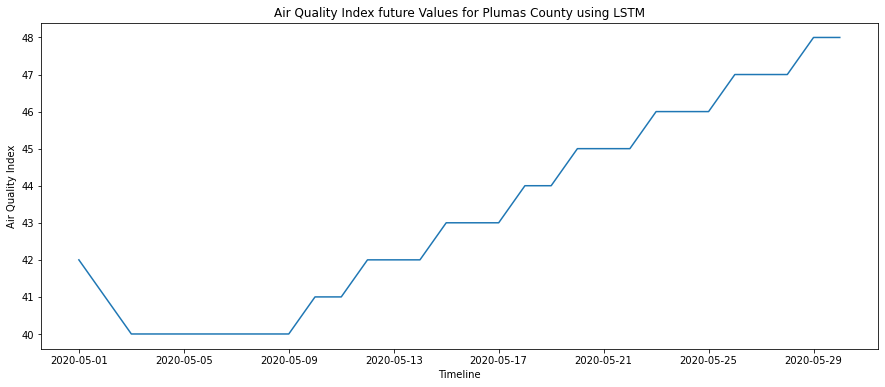

In [91]:
days=list()
i=0
a1=new_data.reset_index()[-1:]['Date'].values[0]
while i<30:
  a1=a1+np.timedelta64(1,'D')
  days.append(a1)
  i=i+1
Final=pd.DataFrame(L_a95)
Final.index=days
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index future Values for Plumas County using LSTM")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(Final)

In [36]:
df = pd.pivot_table(AirQualitybycbsa, values='AQI', index=['Date'],columns='CBSA', aggfunc=np.average)
Top5=df[list(pd.DataFrame(df.mean().sort_values().tail(5)).reset_index()['CBSA'])]
# ploty
layout = go.Layout(
  title="Air Quality Index of 5 Combined Statiscal areas having maximum Air Quality Index",
  xaxis=dict(
      title="Timeline"
  ),
  yaxis=dict(
      title="Air Quality Index"
  ) ) 
fig = go.Figure(layout=layout)
for col in Top5.columns:
    fig.add_trace(go.Scatter(x=Top5.index, y=Top5[col].values,
                             name = col,
                             mode = 'markers+lines',
                             line=dict(shape='linear'),
                             connectgaps=True
                             )
                 )
fig.show()

In [37]:
df=pd.DataFrame(df.mean().sort_values().tail(10)).reset_index()
df.columns=['CBSA','Total Air Quality']
fig = px.pie(df, values='Total Air Quality', names="CBSA",title="Combined statistical areas with maximum Air Quality (Top 10)") 
fig.show()

In [38]:
Top5.columns

Index(['Fresno, CA', 'Phoenix-Mesa-Scottsdale, AZ', 'Merced, CA',
       'Missoula, MT', 'Anchorage, AK'],
      dtype='object', name='CBSA')

In [39]:
Updated=Top5.reset_index()
Jefferson=Updated[['Date','Fresno, CA']]
Jefferson=Jefferson.dropna()
new_data = pd.DataFrame(index=range(0,len(Jefferson)),columns=['Date', 'Fresno, CA'])
for i in range(0,len(Jefferson)):
    new_data['Date'][i] = Jefferson['Date'][i]
    new_data['Fresno, CA'][i] = Jefferson['Fresno, CA'][i]
new_data.shape
new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']
#preparing data
new_data.rename(columns={'Fresno, CA': 'y', 'Date': 'ds'}, inplace=True)
#train and validation
train = new_data[:80]
valid = new_data[80:]
#fit the model
model = Prophet(weekly_seasonality=True,yearly_seasonality=False,daily_seasonality=True)
model.fit(train)
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [40]:
close_prices

,ds
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
116,2020-04-26
117,2020-04-27
118,2020-04-28
119,2020-04-29


In [41]:
new_data.shape

(121, 2)

In [42]:
#rmse
forecast_valid = forecast['yhat'][80:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
print("Root Mean Sequare Error is: ",rms)

Root Mean Sequare Error is:  17.19564796400847


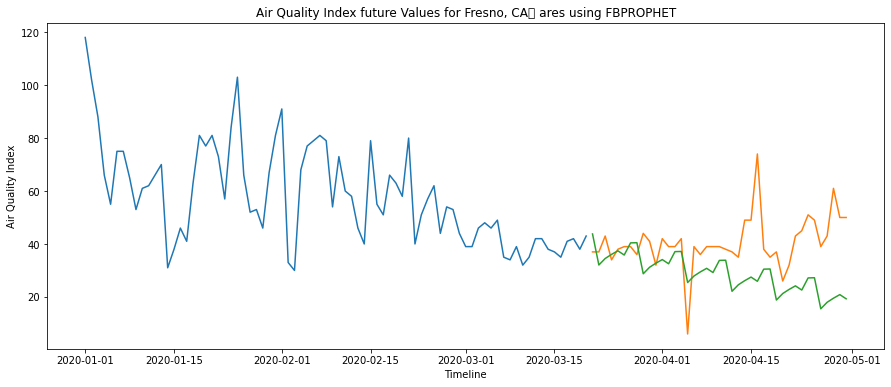

In [43]:
#plot
valid['Predictions'] = forecast_valid.values
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index future Values for Fresno, CA	 ares using FBPROPHET")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

In [44]:
Updated=Top5.reset_index()
Jefferson=Updated[['Date','Fresno, CA']]
Jefferson=Jefferson.dropna()
new_data = pd.DataFrame(index=range(0,len(Jefferson)),columns=['Date', 'Fresno, CA'])
for i in range(0,len(Jefferson)):
    new_data['Date'][i] = Jefferson['Date'][i]
    new_data['Fresno, CA'][i] = Jefferson['Fresno, CA'][i]
new_data.shape
new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']
#preparing data
#new_data.rename(columns={'Jefferson': 'y', 'Date': 'ds'}, inplace=True)
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
#creating train and test sets
dataset = new_data.values
train = dataset[0:80,:]
valid = dataset[80:,:]
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [45]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
#predicting 5000 values, using past 60000 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

20/20 - 0s - loss: 0.0183


In [46]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

13.453753445362992

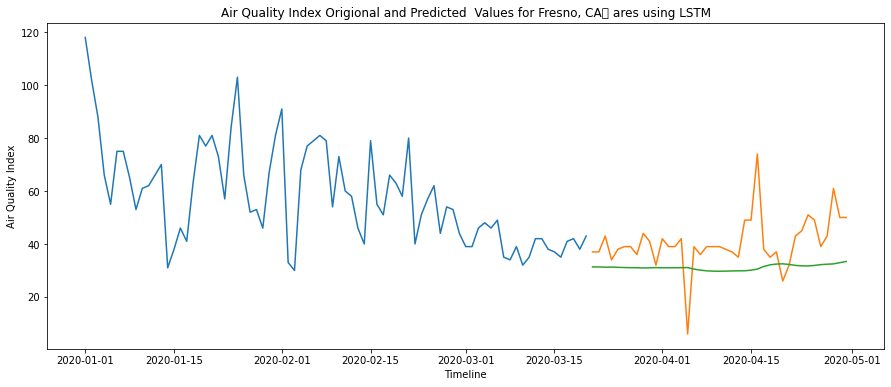

In [47]:
#for plotting
train = new_data[:80]
valid = new_data[80:]
valid['Predictions'] = closing_price
plt.gcf().set_size_inches(15, 6)
plt.plot(train['Fresno, CA'])
plt.title("Air Quality Index Origional and Predicted  Values for Fresno, CA	 ares using LSTM")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(valid[['Fresno, CA','Predictions']])

In [48]:
new_data

,"Fresno, CA"
Date,
2020-01-01,118
2020-01-02,102
2020-01-03,88
2020-01-04,66
2020-01-05,55
...,...
2020-04-26,39
2020-04-27,43
2020-04-28,61


In [49]:
Jefferson=Jefferson.dropna()

In [50]:
Jefferson=Updated[['Date','Fresno, CA']]
Jefferson=Jefferson.dropna()
Jefferson['Date'] = pd.to_datetime(Jefferson['Date'])
new_data = pd.DataFrame()
new_data['Date'] = Jefferson['Date']
new_data['Fresno, CA'] = Jefferson['Fresno, CA']
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
#creating train and test sets
dataset = new_data.values
train = dataset[0:70,:]
valid = dataset[70:,:]
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

10/10 - 0s - loss: 0.0181


In [51]:
inputs1 = new_data[-60:].values
Loop = 0
L_a95 = list()
while Loop<30:
    inputs = inputs1.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(30,inputs.shape[0]):
        X_test.append(inputs[i-30:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    X_test=X_test[-1:]
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    closing_price=int(closing_price)
    inputs1 = np.append(inputs1,closing_price)
    L_a95.append(closing_price)
    Loop=Loop+1

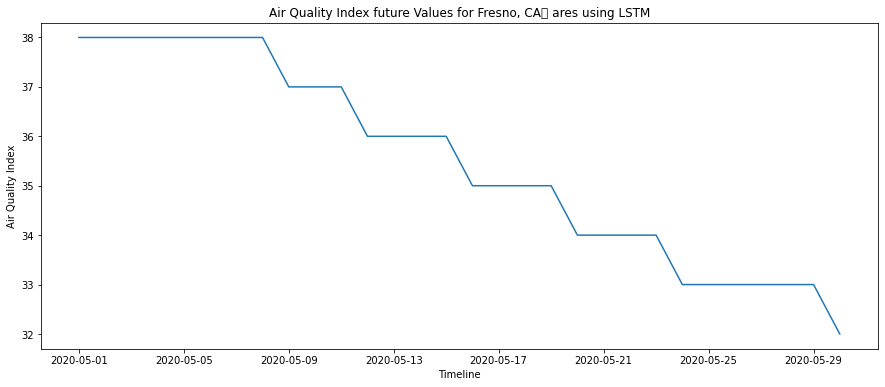

In [52]:
days=list()
i=0
a1=new_data.reset_index()[-1:]['Date'].values[0]
while i<30:
  a1=a1+np.timedelta64(1,'D')
  days.append(a1)
  i=i+1
Final=pd.DataFrame(L_a95)
Final.index=days
plt.gcf().set_size_inches(15, 6)
plt.title("Air Quality Index future Values for Fresno, CA	 ares using LSTM")
plt.xlabel("Timeline")
plt.ylabel("Air Quality Index")
plt.plot(Final)